# Assignment 1. Music Century Classification

**Assignment Responsible**: Natalie Lang.

In this assignment, we will build models to predict which
**century** a piece of music was released.  We will be using the "YearPredictionMSD Data Set"
based on the Million Song Dataset. The data is available to download from the UCI 
Machine Learning Repository. Here are some links about the data:

- https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd
- http://millionsongdataset.com/pages/tasks-demos/#yearrecognition

Note that you are note allowed to import additional packages **(especially not PyTorch)**. One of the objectives is to understand how the training procedure actually operates, before working with PyTorch's autograd engine which does it all for us.


## Question 1. Data (21%)

Start by setting up a Google Colab notebook in which to do your work.
Since you are working with a partner, you might find this link helpful:

- https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The recommended way to work together is pair coding, where you and your partner are sitting together and writing code together. 

To process and read the data, we use the popular `pandas` package for data analysis.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1) # To reproduce our experiment

Now that your notebook is set up, we can load the data into the notebook. The code below provides
two ways of loading the data: directly from the internet, or through mounting Google Drive.
The first method is easier but slower, and the second method is a bit involved at first, but
can save you time later on. You will need to mount Google Drive for later assignments, so we recommend
figuring how to do that now.

Here are some resources to help you get started:

- http.://colab.research.google.com/notebooks/io.ipynb

In [ ]:
load_from_drive = False

if not load_from_drive:
  csv_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip"
else:
  from google.colab import drive
  drive.mount('/content/gdrive')
  csv_path = '/content/gdrive/My Drive/YearPredictionMSD.txt.zip' # TODO - UPDATE ME WITH THE TRUE PATH!

t_label = ["year"]
x_labels = ["var%d" % i for i in range(1, 91)]
df = pandas.read_csv(csv_path, names=t_label + x_labels)

Now that the data is loaded to your Colab notebook, you should be able to display the Pandas
DataFrame `df` as a table:

In [ ]:
df

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.0500

To set up our data for classification, we'll use the "year" field to represent
whether a song was released in the 20-th century. In our case `df["year"]` will be 1 if
the year was released after 2000, and 0 otherwise.

In [ ]:
df["year"] = df["year"].map(lambda x: int(x > 2000))

In [ ]:
df.head(20)

,year,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,...,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,var69,var70,var71,var72,var73,var74,var75,var76,var77,var78,var79,var80,var81,var82,var83,var84,var85,var86,var87,var88,var89,var90
0,1,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,1,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,1,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,1,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,1,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34

### Part (a) -- 7%

The data set description text asks us to respect the below train/test split to
avoid the "producer effect". That is, we want to make sure that no song from a single artist
ends up in both the training and test set.

Explain why it would be problematic to have
some songs from an artist in the training set, and other songs from the same artist in the
test set. (Hint: Remember that we want our test accuracy to predict how well the model
will perform in practice on a song it hasn't learned about.)

In [ ]:
df_train = df[:463715]
df_test = df[463715:]

# convert to numpy
train_xs = df_train[x_labels].to_numpy()
train_ts = df_train[t_label].to_numpy()
test_xs = df_test[x_labels].to_numpy()
test_ts = df_test[t_label].to_numpy()

# Write your explanation here
'''
To evaluate our model properly, we want to know how well the model will perform over a new songs that it hasn't encountered before.
Using songs from the same artist for both the training set and the test set can lead to a situation in which the model learns to extract features based on the singer,
e.g., the singer's voice, and will decide based on those features.
In this scenario, the model might perform well on samples of songs in the test where their corresponding singers also appeared in the train set.
But this doesn't guarantee that the model will generalize for songs in the test set that their singers didn't appear in the train set.
'''


"\nTo evaluate our model properly, we want to know how well the model will perform over a new songs that it hasn't encountered before.\nUsing songs from the same artist for both the training set and the test set can lead to a situation in which the model learns to extract features based on the singer,\ne.g., the singer's voice, and will decide based on those features.\nIn this scenario, the model might perform well on samples of songs in the test where their corresponding singers also appeared in the train set.\nBut this doesn't guarantee that the model will generalize for songs in the test set that their singers didn't appear in the train set.\n"

### Part (b) -- 7%

It can be beneficial to **normalize** the columns, so that each column (feature)
has the *same* mean and standard deviation.

In [ ]:
feature_means = df_train.mean()[1:].to_numpy() # the [1:] removes the mean of the "year" field
feature_stds  = df_train.std()[1:].to_numpy()

train_norm_xs = (train_xs - feature_means) / feature_stds
test_norm_xs = (test_xs - feature_means) / feature_stds

Notice how in our code, we normalized the test set using the *training data means and standard deviations*.
This is *not* a bug.

Explain why it would be improper to compute and use test set means
and standard deviations. (Hint: Remember what we want to use the test accuracy to measure.)

In [ ]:
# Write your explanation here
"""
We normalize the data with respect to the training set to make the input data used for training "more identical distributed" during training.
We are using test data to evaluate our model performance over new unseen data.
If we are using the average and standard deviation of this test set to normalize it, we enforce dependency between different samples in the test set. 
This harms the idea of model evaluation over new unseen data, e.g., if we evaluate our model for two different test sets, both contain some identical samples.
Following this approach will lead to different outcomes for the same input sample (because the average and the standard deviation will be different), which demonstrates the problem with this approach.
"""

'\nWe normalize the data with respect to the training set to make the input data used for training "more identical distributed" during training.\nWe are using test data to evaluate our model performance over new unseen data.\nIf we are using the average and standard deviation of this test set to normalize it, we enforce dependency between different samples in the test set. \nThis harms the idea of model evaluation over new unseen data, e.g., if we evaluate our model for two different test sets, both contain some identical samples.\nFollowing this approach will lead to different outcomes for the same input sample (because the average and the standard deviation will be different), which demonstrates the problem with this approach.\n'

### Part (c) -- 7%

Finally, we'll move some of the data in our training set into a validation set.

Explain why we should limit how many times we use the test set, and that we should use the validation
set during the model building process.

In [ ]:
# shuffle the training set
reindex = np.random.permutation(len(train_xs))
train_xs = train_xs[reindex]
train_norm_xs = train_norm_xs[reindex]
train_ts = train_ts[reindex]

# use the first 50000 elements of `train_xs` as the validation set
train_xs, val_xs           = train_xs[50000:], train_xs[:50000]
train_norm_xs, val_norm_xs = train_norm_xs[50000:], train_norm_xs[:50000]
train_ts, val_ts           = train_ts[50000:], train_ts[:50000]

# Write your explanation here
'''
If we will not limit the times that we are using the test set, we may encounter overfitting phenomena over the test data, 
which in turn will lead to good preformance over the test set, this phenomena may occur becuase we are tuning our model to achieve
good preformance over a specific set of test samples. 
This is a problem because the main reason that we are using a test set is to evaluate our model preformance over an unseen data,
i.e., we test how well the training procedure will be able to generalize for unseen samples. 
We can avoid this issue by examing our model preformance (during the bulding procedure) via
another set which we call "validation" set. The validation dataset is different from the test dataset, 
both datasets are held back from the training of the model,but the validation set used to give an unbiased preformance estimation
of the final tuned model when comparing between different final models."
'''

'\nIf we will not limit the times that we are using the test set, we may encounter overfitting phenomena over the test data, \nwhich in turn will lead to good preformance over the test set, this phenomena may occur becuase we are tuning our model to achieve\ngood preformance over a specific set of test samples. \nThis is a problem because the main reason that we are using a test set is to evaluate our model preformance over an unseen data,\ni.e., we test how well the training procedure will be able to generalize for unseen samples. \nWe can avoid this issue by examing our model preformance (during the bulding procedure) via\nanother set which we call "validation" set. The validation dataset is different from the test dataset, \nboth datasets are held back from the training of the model,but the validation set used to give an unbiased preformance estimation\nof the final tuned model when comparing between different final models."\n'

## Part 2. Classification (79%)

We will first build a *classification* model to perform decade classification.
These helper functions are written for you. All other code that you write in this section should be vectorized whenever possible (i.e., avoid unnecessary loops).

In [ ]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))
    
def cross_entropy(t, y):
  epsilon=1e-15 #to avoid log(0)
  return -t * np.log(y+epsilon) - (1 - t) * np.log(1 - y+epsilon)

def cost(y, t):
  return np.mean(cross_entropy(t, y))

def get_accuracy(y, t):
  acc = 0
  N = 0
  for i in range(len(y)):
    N += 1
    if (y[i] >= 0.5 and t[i] == 1) or (y[i] < 0.5 and t[i] == 0):
      acc += 1
  return acc / N

### Part (a) -- 7%

Write a function `pred` that computes the prediction `y` based on logistic regression, i.e., a single layer with weights `w` and bias `b`. The output is given by: 
\begin{equation}
y = \sigma({\bf w}^T {\bf x} + b),
\end{equation}
where the value of $y$ is an estimate of the probability that the song is released in the current century, namely ${\rm year} =1$.

In [ ]:
def pred(w, b, X):
  """
  Returns the prediction `y` of the target based on the weights `w` and scalar 
  bias `b`.

  Preconditions: np.shape(w) == (90,)
                 type(b) == float
                 np.shape(X) = (N, 90) for some N

  >>> pred(np.zeros(90), 1, np.ones([2, 90]))
  array([0.73105858, 0.73105858]) # It's okay if your output differs in the last
  decimals
  """
  return sigmoid(np.dot(X,w)+b)


### Part (b) -- 7%

Write a function `derivative_cost` that computes and returns the gradients 
$\frac{\partial\mathcal{L}}{\partial {\bf w}}$ and
$\frac{\partial\mathcal{L}}{\partial b}$. Here, `X` is the input, `y` is the prediction, and `t` is the true label.




In [ ]:
def derivative_cost(X, y, t):
  """
  Returns a tuple containing the gradients dLdw and dLdb.

  Precondition: np.shape(X) == (N, 90) for some N
                np.shape(y) == (N,)
                np.shape(t) == (N,)

  Postcondition: np.shape(dLdw) = (90,)
           type(dLdb) = float
  """
  N = np.shape(y)[0]
  dLdb = np.mean(y - t)
  dLdw = 1/N * np.dot(y - t,X)
  return (dLdw, dLdb)

# **Explenation on Gradients**




First we define our loss function as followed:

$L(w,b)=-\frac{1}{N}\sum_{n=1}^{N}t_n\log(y_n)+(1-t_n)\log(1-y_n)$.

Let $z_n = \mathbf{w}^T\mathbf{x}_n+b$

where we denote bold letter as a vector.

By the chain-rule:

$\frac{\partial L}{\partial w}= \sum_{n=1}^{N}\frac{\partial L}{\partial y_n}\cdot \frac{\partial y_n}{\partial z_n} \cdot \frac{\partial z_n}{\partial w}$

$\frac{\partial L}{\partial b}= \sum_{n=1}^{N} \frac{\partial L}{\partial y_n}\cdot \frac{\partial y_n}{\partial z_n} \cdot \frac{\partial z_n}{\partial b}$ 

where:

$\frac{\partial L}{\partial y_n}=-\frac{1}{N}(\frac{t_n}{y_n}-\frac{1-t_n}{1-y_n} )=\frac{y_n-t_n}{N \cdot y_n \cdot (1-y_n)}$,

$\frac{\partial y_n}{\partial z_n} = \sigma'(z_n) = \sigma(z_n)(1-\sigma(z_n))=y_n(1-y_n)$

$\frac{\partial z_n}{\partial b} =1$,

$\frac{\partial z_n}{\partial w}=\mathbf{x}_n$

These boils down to:

$\frac{\partial L}{\partial b} = \sum_{n=1}^{N} \frac{y_n-t_n}{N \cdot y_n \cdot (1-y_n)} \cdot y_n(1-y_n) \cdot 1 = \frac{1}{N}\sum_{n=1}^{N}y_n-t_n$

$\frac{\partial L}{\partial w} = \sum_{n=1}^{N} \frac{y_n-t_n}{N \cdot y_n \cdot (1-y_n)} \cdot y_n(1-y_n) \cdot \mathbf{x}_b = \frac{1}{N}\sum_{n=1}^{N}(y_n-t_n)\mathbf{x}_n$






### Part (c) -- 7%

We can check that our derivative is implemented correctly using the finite difference rule. In 1D, the
finite difference rule tells us that for small $h$, we should have

$$\frac{f(x+h) - f(x)}{h} \approx f'(x)$$

Show that $\frac{\partial\mathcal{L}}{\partial b}$  is implement correctly
by comparing the result from `derivative_cost` with the empirical cost derivative computed using the above numerical approximation.


In [ ]:
# Your code goes here
def compute_analytical_deriviate(w,b,t,X,h=1e-05):
  '''
  First we calculate the derivative with respect to the bias term
  '''
  # Calculate the predications
  y = pred(w, b, X) 
  # Calculate the loss of those predications
  L = cost(y,t)
  y_new = pred(w,b+h,X)
  L_new = cost(y_new,t)

  # Calculate the analytic derivative
  deriviate_b =(L_new-L)/h

  '''
  Now we calculate the derivative with respect to the weights
  '''
  L_new = np.zeros(len(w))
  deriviate_w = np.zeros(len(w))
  for weight_idx in range(len(w)):
    # Compute cost of w[weight_idx] + h
    w_new = np.copy(w)
    w_new[weight_idx] = w_new[weight_idx] + h
    # Calculate the predications
    y_new = pred(w_new,b,X)
    # Calculate the loss of those predications
    L_new[weight_idx]=cost(y_new,t)
    deriviate_w[weight_idx] = (L_new[weight_idx]-L)/h
  
  return deriviate_w, deriviate_b


Now we are going to check our derivative using an example

In [ ]:
w=np.zeros(90)
h=1e-05
b=1
t=np.array([1,1])
X=np.ones([2, 90])
y = pred(w, b, X)
dw,db = derivative_cost(X,y,t)
dw_analytic, db_analytic = compute_analytical_deriviate(w,b,t,X,h)
print("The bias analytical derivative results is -", db_analytic)
print("The bias algorithm derivative results is - ", db)
print(f"The error is {np.abs(db-db_analytic)}")

The bias analytical derivative results is - -0.26894043830827385
The bias algorithm derivative results is -  -0.2689414213699951
The error is 9.830617212491788e-07


### Part (d) -- 7%

Show that $\frac{\partial\mathcal{L}}{\partial {\bf w}}$  is implement correctly.

In [ ]:
print("The weights analytical derivative results is -", dw_analytic)
print("The weights algorithm derivative results is - ", dw)
print(f"The maximal error is {np.max(np.abs(dw-dw_analytic))}")

The weights analytical derivative results is - [-0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044 -0.26894044
 -0.

Now we will check over couple of real examples from the training set

In [ ]:
h = 1e-9;
# First we initialize the weights by random numbers
w=np.random.rand(90)
b=np.random.rand(1)

# Now we extract the actual samples from the dataset
t = (train_ts[:1]).squeeze()
X = train_norm_xs[:1]
y = pred(w, b, X)

dw,db = derivative_cost(X,y,t)
dw_analytic, db_analytic = compute_analytical_deriviate(w,b,t,X,h)
print("The analytical derivative bias results is -", db_analytic)
print("The algorithm derivative bias results is - ", db)
print(f"Bias Error is {np.abs(db-db_analytic)}")

print("The analytical derivative weights results is -", dw_analytic)
print("The algorithm derivative weights results is - ", dw)
print(f"Maximal weights Error is {np.max(np.abs(dw-dw_analytic))}")

The analytical derivative bias results is - -0.9672760370449395
The algorithm derivative bias results is -  -0.9672759967800327
Bias Error is 4.0264906742137896e-08
The analytical derivative weights results is - [ 0.97880459  1.33712197  1.5150321   1.17287824 -0.1407332  -0.28086733
  0.99645137  1.66069425  0.34143222  2.53612864 -0.60000049  0.2660081
 -0.16358959  0.27339908 -0.18315438 -0.02620393  0.57133454  0.29290792
 -0.22191848 -0.26613023  0.32624214 -0.12356471  0.2247269  -0.1315108
  0.79538109  0.54556981  0.37574432  0.19421131  0.50898086  0.31249137
 -0.95565378 -0.54595706  0.15626922  0.11944934 -0.86183682 -0.96469277
 -0.30012703 -0.25347191 -0.2640399  -0.20129987  0.12283019  0.02585665
 -0.75847728  0.77280982  0.88499963 -0.2634799   0.25427704  0.86388496
 -0.74310602 -0.05215162  0.02074074 -0.18614754  0.64476735  0.68632078
 -0.79160367 -0.5105103  -0.51600768  0.62609251 -0.36517989  1.05336495
  0.91098018  0.16509771  0.39282799  0.36208059 -1.05262732

### Part (e) -- 7%

Now that you have a gradient function that works, we can actually run gradient descent. 
Complete the following code that will run stochastic: gradient descent training:

In [ ]:
def run_gradient_descent(w0, b0, mu=0.1, batch_size=100, max_iters=100):
  """Return the values of (w, b) after running gradient descent for max_iters.
  We use:
    - train_norm_xs and train_ts as the training set
    - val_norm_xs and val_ts as the test set
    - mu as the learning rate
    - (w0, b0) as the initial values of (w, b)

  Precondition: np.shape(w0) == (90,)
                type(b0) == float
 
  Postcondition: np.shape(w) == (90,)
                 type(b) == float
  """
  w = w0
  b = b0
  iter = 0
  val_loss = []
  
  while iter < max_iters:
    # shuffle the training set (there is code above for how to do this)
    new_indices = np.random.permutation(len(train_norm_xs))
    train_norm_xs_temp = train_norm_xs[new_indices]
    train_ts_temp = train_ts[new_indices]

    for i in range(0, len(train_norm_xs), batch_size): # iterate over each minibatch
      # minibatch that we are working with:
      X = train_norm_xs_temp[i:(i + batch_size)]
      t = train_ts_temp[i:(i + batch_size), 0]

      # since len(train_norm_xs) does not divide batch_size evenly, we will skip over
      # the "last" minibatch
      if np.shape(X)[0] != batch_size:
        continue

      # compute the prediction
      y = pred(w, b, X)
      # update w and b
      dw,db = derivative_cost(X,y,t)
      w -= mu*dw
      b -= mu*db

      # increment the iteration count
      iter += 1
      # compute and print the *validation* loss and accuracy
      if (iter % 10 == 0):
        # Calculate the predications over the validation data
        y_val = pred(w,b,val_norm_xs)
        # Calculate the cost over the predications 
        val_cost = cost(y_val,val_ts.squeeze())
        val_acc = get_accuracy(y_val, val_ts)
        print("Iter %d. [Val Acc %.0f%%, Loss %f]" % (iter, val_acc * 100, val_cost))
        val_loss.append(val_cost)
      if iter >= max_iters:
        break

      # Think what parameters you should return for further use
      # We choose to return in addition to w and b the validation loss in order to evaluate our model training procedure over unseen data.
  return w, b, val_loss



### Part (f) -- 7%

Call `run_gradient_descent` with the weights and biases all initialized to zero.
Show that if the learning rate $\mu$ is too small, then convergence is slow.
Also, show that if $\mu$ is too large, then the optimization algorirthm does not converge. The demonstration should be made using plots showing these effects.

mu= 0.005 :
Iter 10. [Val Acc 64%, Loss 0.689537]
Iter 20. [Val Acc 64%, Loss 0.686243]
Iter 30. [Val Acc 65%, Loss 0.683223]
Iter 40. [Val Acc 66%, Loss 0.680522]
Iter 50. [Val Acc 66%, Loss 0.677757]
Iter 60. [Val Acc 66%, Loss 0.675389]
Iter 70. [Val Acc 66%, Loss 0.673272]
Iter 80. [Val Acc 66%, Loss 0.670915]
Iter 90. [Val Acc 66%, Loss 0.668803]
Iter 100. [Val Acc 67%, Loss 0.666691]
Iter 110. [Val Acc 67%, Loss 0.664770]
Iter 120. [Val Acc 67%, Loss 0.663073]
Iter 130. [Val Acc 67%, Loss 0.661280]
Iter 140. [Val Acc 67%, Loss 0.659441]
Iter 150. [Val Acc 67%, Loss 0.657792]
Iter 160. [Val Acc 67%, Loss 0.656151]
Iter 170. [Val Acc 67%, Loss 0.654577]
Iter 180. [Val Acc 68%, Loss 0.653243]
Iter 190. [Val Acc 68%, Loss 0.651831]
Iter 200. [Val Acc 68%, Loss 0.650391]
Iter 210. [Val Acc 68%, Loss 0.649131]
Iter 220. [Val Acc 68%, Loss 0.647609]
Iter 230. [Val Acc 68%, Loss 0.646184]
Iter 240. [Val Acc 68%, Loss 0.645205]
Iter 250. [Val Acc 68%, Loss 0.644035]
Iter 260. [Val Acc 68%

Text(0.5, 1.0, 'Learning rate convergance properties')

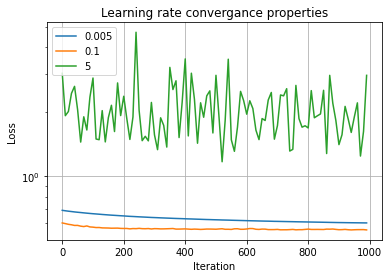

In [ ]:
w0 = np.zeros(90)
b0 = 0
Iterations = 1000
mus=[0.005,0.1,5]
for mu in mus:
  print("mu=",mu,":")
  w,b,losses=run_gradient_descent(w0,b0,mu, max_iters=Iterations)
  print("-------------------------")
  plt.semilogy(range(0,Iterations,10),losses)

plt.legend(mus,loc='best')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.title("Learning rate convergance properties")


We conclude from the figure above that for a small learning rate, the algorithm may be capable to converge but very slowly due to the small changes in the parameters space. On the other hand, we see that by using too large learning rate, the algorithm is incapable to converge due to the large changes in the parameters space. Thus, we conclude from the empirical results that choosing a learning rate somewhere in between those learning rates leads to the best performance. 
We explain this phenomenon by the fact that the algorithm can change its parameters efficiently towards a good optimum. Meaning that we have found a good trade-off between a small enough step size that allows convergence but not too small such that it leads to faster convergence rate to a good enough optimum.



### Part (g) -- 7%

Find the optimial value of ${\bf w}$ and $b$ using your code. Explain how you chose
the learning rate $\mu$ and the batch size. Show plots demostrating good and bad behaviours.

In [ ]:
'''
Hyperparameters search
'''

mus = [0.01, 0.1, 0.5, 1]
batch_sizes = [1, 64, 1024, 50000]
Iterations = 1000
loss_results = np.zeros((len(mus),len(batch_sizes)))
w_history = np.zeros((len(mus),len(batch_sizes), 90))
b_history = np.zeros((len(mus),len(batch_sizes), 1))

w0 = np.random.randn(90)
b0 = np.random.randn(1)[0]

for mu_idx,mu in enumerate(mus):
  for minibatch_idx, minibatch_size in enumerate(batch_sizes):
    print("mu=",mu, 'batch_size=', minibatch_size, ':')
    w,b,losses=run_gradient_descent(w0,b0,mu, max_iters=Iterations)
    print("-------------------------")
    loss_results[mu_idx][minibatch_idx] = losses[-1]
    w_history[mu_idx][minibatch_idx] = w
    b_history[mu_idx][minibatch_idx] = b

best_mu_idx, best_batch_size_idx = np.unravel_index(np.argmin(loss_results, axis=None), loss_results.shape)
print("optimal mu=",mus[best_mu_idx], 'optimal batch_size=', batch_sizes[best_batch_size_idx])
'''
Save the optimal weight and bias
'''
opt_w = w_history[best_mu_idx][best_batch_size_idx]
opt_b = b_history[best_mu_idx][best_batch_size_idx]

mu= 0.01 batch_size= 1 :
Iter 10. [Val Acc 47%, Loss 2.747708]
Iter 20. [Val Acc 47%, Loss 2.714000]
Iter 30. [Val Acc 47%, Loss 2.686253]
Iter 40. [Val Acc 47%, Loss 2.659955]
Iter 50. [Val Acc 47%, Loss 2.633081]
Iter 60. [Val Acc 47%, Loss 2.603889]
Iter 70. [Val Acc 48%, Loss 2.580692]
Iter 80. [Val Acc 48%, Loss 2.557785]
Iter 90. [Val Acc 48%, Loss 2.530571]
Iter 100. [Val Acc 48%, Loss 2.503728]
Iter 110. [Val Acc 48%, Loss 2.479285]
Iter 120. [Val Acc 48%, Loss 2.455511]
Iter 130. [Val Acc 48%, Loss 2.436268]
Iter 140. [Val Acc 48%, Loss 2.415122]
Iter 150. [Val Acc 48%, Loss 2.394333]
Iter 160. [Val Acc 48%, Loss 2.377478]
Iter 170. [Val Acc 48%, Loss 2.357796]
Iter 180. [Val Acc 48%, Loss 2.338882]
Iter 190. [Val Acc 48%, Loss 2.319985]
Iter 200. [Val Acc 48%, Loss 2.298555]
Iter 210. [Val Acc 48%, Loss 2.279912]
Iter 220. [Val Acc 49%, Loss 2.262655]
Iter 230. [Val Acc 49%, Loss 2.244858]
Iter 240. [Val Acc 49%, Loss 2.228405]
Iter 250. [Val Acc 49%, Loss 2.213221]
Iter 260.

We found the optimal weights and biases by scanning over a range of different learning rates and batch sizes for 1000 iterations each and then picking the weights and biases in which the loss over the validation set was minimal.
The best weights and biases were observed when $\mu=0.1$ and batch_size = 50000 (the size of the training data set). The best results are achieved when the batch size is maximal. The reason is that the number of iterations is the number of update steps. Because this number is constant (1000), we have the same number of updates independently of the batch size. Thus, when the batch size is large, as we learned in the lectures, we get a better approximation of the true gradient, and hence the results are better.
It is important to mention that we should not conclude that the best choice is always picking the largest batch size. The reason is that if we measure the validation loss per epoch (for a fixed number of epochs), the number of update steps with a large batch size will be smaller than the number of updates when the batch size is smaller which may lead to worse performance. Furthermore, a smaller batch size can assist the algorithm in avoiding it from stuck in a local minimum or a saddle point due to the noisier gradient.

monte_carlo: 0
mu= 0.1 batch_size= 1 :
Iter 10. [Val Acc 50%, Loss 2.988975]
Iter 20. [Val Acc 50%, Loss 2.667662]
Iter 30. [Val Acc 51%, Loss 2.407711]
Iter 40. [Val Acc 52%, Loss 2.213487]
Iter 50. [Val Acc 53%, Loss 2.034886]
Iter 60. [Val Acc 54%, Loss 1.918314]
Iter 70. [Val Acc 55%, Loss 1.783832]
Iter 80. [Val Acc 55%, Loss 1.679106]
Iter 90. [Val Acc 56%, Loss 1.575458]
Iter 100. [Val Acc 57%, Loss 1.505344]
Iter 110. [Val Acc 57%, Loss 1.429909]
Iter 120. [Val Acc 58%, Loss 1.359682]
Iter 130. [Val Acc 59%, Loss 1.299835]
Iter 140. [Val Acc 59%, Loss 1.230887]
Iter 150. [Val Acc 60%, Loss 1.174670]
Iter 160. [Val Acc 61%, Loss 1.117459]
Iter 170. [Val Acc 61%, Loss 1.073838]
Iter 180. [Val Acc 62%, Loss 1.035060]
Iter 190. [Val Acc 62%, Loss 1.000929]
Iter 200. [Val Acc 63%, Loss 0.972118]
Iter 210. [Val Acc 63%, Loss 0.943865]
Iter 220. [Val Acc 63%, Loss 0.914478]
Iter 230. [Val Acc 64%, Loss 0.887211]
Iter 240. [Val Acc 64%, Loss 0.860926]
Iter 250. [Val Acc 64%, Loss 0.843

Text(0.5, 1.0, 'Batch size convergance properties')

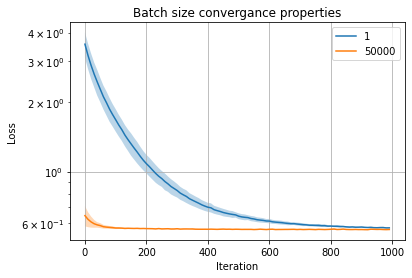

In [ ]:


# Write your code here
mu = 0.1
batch_sizes = [1,50000]
Iterations = 1000
plt.figure()
MC_SIZE = 3
losses_vec = np.zeros((MC_SIZE, len(batch_sizes), int(Iterations/10)))
for mc_indx in range(MC_SIZE):
    w0 = np.random.randn(90)
    b0 = np.random.randn(1)[0]
    print("monte_carlo:", mc_indx)
    for curr_idx, minibatch_size in enumerate(batch_sizes):
      print("mu=",mu, 'batch_size=', minibatch_size, ':')
      w,b,losses=run_gradient_descent(w0,b0,mu, max_iters=Iterations)
      losses_vec[mc_indx][curr_idx] = losses
      print("-------------------------")


mean = np.mean(losses_vec,axis=0)
std = np.std(losses_vec,axis=0)
for curr_idx, minibatch_size in enumerate(batch_sizes):
  plt.semilogy(range(0,Iterations,10),mean[curr_idx], label=f'{minibatch_size}')
  y_neg_error = mean[curr_idx]-std[curr_idx]
  y_pos_error = mean[curr_idx]+std[curr_idx]
  plt.fill_between(range(0,Iterations,10), y_neg_error, y_pos_error, alpha=0.3)
plt.legend(loc='best')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.title("Batch size convergance properties")



For $\mu=0.1$ and batch size 1 we can see from this figure that it takes more iterations for the validation loss to converge (compared with batch size 50000) because the estimation of the gradient is based on one sample, which makes this estimation very noisy. Through the training procedure we see that a minibatch with smaller size suffer from higher variance when applying Monte Carlo experiment with random parameters initialization.




### Part (h) -- 15%

Using the values of `w` and `b` from part (g), compute your training accuracy, validation accuracy,
and test accuracy. Are there any differences between those three values? If so, why?

In [ ]:
train_ys=pred(opt_w,opt_b,train_norm_xs)
test_ys=pred(opt_w,opt_b,test_norm_xs)
val_ys=pred(opt_w,opt_b,val_norm_xs)


train_acc = get_accuracy(train_ys,train_ts)
val_acc = get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)


train_acc =  0.7315905877234328  val_acc =  0.73532  test_acc =  0.7247143133836916


Both train and validation accuracies are better than the test accuracy, we explain this phenomenoa by the fact that we didn't see the test data during the model building process, so we expect to encounter minor degradation in the model performance over the new unseen data.

Moreover, we can see that the gap between the train and test data is not significant and therefore we conclude that the model can extract meaningful information from the training dataset.
Meaning that the model is capable to perform similarly over unseen data, e.g., the model is well generalized. 

Regarding the validation accuracy, we have tuned our model hyperparameters(Learning rate and Batch size) such that it achieves the best performance over the validation data, therefore, we shall expect to achieve better results in the validation data than the test data, and this is indeed the result that we've achieved. 


### Part (i) -- 15%

Writing a classifier like this is instructive, and helps you understand what happens when
we train a model. However, in practice, we rarely write model building and training code
from scratch. Instead, we typically use one of the well-tested libraries available in a package.

Use `sklearn.linear_model.LogisticRegression` to build a linear classifier, and make predictions about the test set. Start by reading the
[API documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

Compute the training, validation and test accuracy of this model.

In [ ]:
import sklearn.linear_model

model = sklearn.linear_model.LogisticRegression()
model.fit(train_norm_xs, train_ts.squeeze())
train_ys = model.predict(train_norm_xs)
test_ys = model.predict(test_norm_xs)
val_ys = model.predict(val_norm_xs)
train_acc = get_accuracy(train_ys,train_ts)
val_acc = get_accuracy(val_ys,val_ts)
test_acc =  get_accuracy(test_ys,test_ts)

print('train_acc = ', train_acc, ' val_acc = ', val_acc, ' test_acc = ', test_acc)

train_acc =  0.7323979067715698  val_acc =  0.73642  test_acc =  0.7265736974627155


**This parts helps by checking if the code worked.**
**Check if you get similar results, if not repair your code**
